In [1]:
################################################################################
#Michael Guerzhoy and Davi Frossard, 2016
#AlexNet implementation in TensorFlow, with weights
#Details: 
#http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/
#
#With code from https://github.com/ethereon/caffe-tensorflow
#Model from  https://github.com/BVLC/caffe/tree/master/models/bvlc_alexnet
#Weights from Caffe converted using https://github.com/ethereon/caffe-tensorflow
#
#
################################################################################

from numpy import *
import os
#from pylab import *
import numpy as np
#import matplotlib.pyplot as plt
#import matplotlib.cbook as cbook
import time
from scipy.misc import imread
from scipy.misc import imresize
import matplotlib.image as mpimg
from scipy.ndimage import filters
import urllib
from numpy import random


import tensorflow as tf

from caffe_classes import class_names

train_x = zeros((1, 227,227,3)).astype(float32)
train_y = zeros((1, 1000))
xdim = train_x.shape[1:]
ydim = train_y.shape[1]



################################################################################
#Read Image, and change to BGR


im1 = (imread("laska.png")[:,:,:3]).astype(float32)
im1 = im1 - mean(im1)
im1[:, :, 0], im1[:, :, 2] = im1[:, :, 2], im1[:, :, 0]

im2 = (imread("poodle.png")[:,:,:3]).astype(float32)
im2[:, :, 0], im2[:, :, 2] = im2[:, :, 2], im2[:, :, 0]


################################################################################

# (self.feed('data')
#         .conv(11, 11, 96, 4, 4, padding='VALID', name='conv1')
#         .lrn(2, 2e-05, 0.75, name='norm1')
#         .max_pool(3, 3, 2, 2, padding='VALID', name='pool1')
#         .conv(5, 5, 256, 1, 1, group=2, name='conv2')
#         .lrn(2, 2e-05, 0.75, name='norm2')
#         .max_pool(3, 3, 2, 2, padding='VALID', name='pool2')
#         .conv(3, 3, 384, 1, 1, name='conv3')
#         .conv(3, 3, 384, 1, 1, group=2, name='conv4')
#         .conv(3, 3, 256, 1, 1, group=2, name='conv5')
#         .fc(4096, name='fc6')
#         .fc(4096, name='fc7')
#         .fc(1000, relu=False, name='fc8')
#         .softmax(name='prob'))

#In Python 3.5, change this to:
net_data = load(open("bvlc_alexnet.npy", "rb"), encoding="latin1").item()
#net_data = load("bvlc_alexnet.npy").item()

def conv(input, kernel, biases, k_h, k_w, c_o, s_h, s_w,  padding="VALID", group=1):
    '''From https://github.com/ethereon/caffe-tensorflow
    '''
    c_i = input.get_shape()[-1]
    assert c_i%group==0
    assert c_o%group==0
    convolve = lambda i, k: tf.nn.conv2d(i, k, [1, s_h, s_w, 1], padding=padding)
    
    
    if group==1:
        conv = convolve(input, kernel)
    else:
        input_groups =  tf.split(input, group, 3)   #tf.split(3, group, input)
        kernel_groups = tf.split(kernel, group, 3)  #tf.split(3, group, kernel) 
        output_groups = [convolve(i, k) for i,k in zip(input_groups, kernel_groups)]
        conv = tf.concat(output_groups, 3)          #tf.concat(3, output_groups)
    return  tf.reshape(tf.nn.bias_add(conv, biases), [-1]+conv.get_shape().as_list()[1:])



x = tf.placeholder(tf.float32, (None,) + xdim)


#conv1
#conv(11, 11, 96, 4, 4, padding='VALID', name='conv1')
k_h = 11; k_w = 11; c_o = 96; s_h = 4; s_w = 4
conv1W = tf.Variable(net_data["conv1"][0])
conv1b = tf.Variable(net_data["conv1"][1])
conv1_in = conv(x, conv1W, conv1b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=1)
conv1 = tf.nn.relu(conv1_in)

#lrn1
#lrn(2, 2e-05, 0.75, name='norm1')
radius = 2; alpha = 2e-05; beta = 0.75; bias = 1.0
lrn1 = tf.nn.local_response_normalization(conv1,
                                                  depth_radius=radius,
                                                  alpha=alpha,
                                                  beta=beta,
                                                  bias=bias)

#maxpool1
#max_pool(3, 3, 2, 2, padding='VALID', name='pool1')
k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
maxpool1 = tf.nn.max_pool(lrn1, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)


#conv2
#conv(5, 5, 256, 1, 1, group=2, name='conv2')
k_h = 5; k_w = 5; c_o = 256; s_h = 1; s_w = 1; group = 2
conv2W = tf.Variable(net_data["conv2"][0])
conv2b = tf.Variable(net_data["conv2"][1])
conv2_in = conv(maxpool1, conv2W, conv2b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
conv2 = tf.nn.relu(conv2_in)


#lrn2
#lrn(2, 2e-05, 0.75, name='norm2')
radius = 2; alpha = 2e-05; beta = 0.75; bias = 1.0
lrn2 = tf.nn.local_response_normalization(conv2,
                                                  depth_radius=radius,
                                                  alpha=alpha,
                                                  beta=beta,
                                                  bias=bias)

#maxpool2
#max_pool(3, 3, 2, 2, padding='VALID', name='pool2')                                                  
k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
maxpool2 = tf.nn.max_pool(lrn2, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)

#conv3
#conv(3, 3, 384, 1, 1, name='conv3')
k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 1
conv3W = tf.Variable(net_data["conv3"][0])
conv3b = tf.Variable(net_data["conv3"][1])
conv3_in = conv(maxpool2, conv3W, conv3b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
conv3 = tf.nn.relu(conv3_in)

#conv4
#conv(3, 3, 384, 1, 1, group=2, name='conv4')
k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 2
conv4W = tf.Variable(net_data["conv4"][0])
conv4b = tf.Variable(net_data["conv4"][1])
conv4_in = conv(conv3, conv4W, conv4b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
conv4 = tf.nn.relu(conv4_in)


#conv5
#conv(3, 3, 256, 1, 1, group=2, name='conv5')
k_h = 3; k_w = 3; c_o = 256; s_h = 1; s_w = 1; group = 2
conv5W = tf.Variable(net_data["conv5"][0])
conv5b = tf.Variable(net_data["conv5"][1])
conv5_in = conv(conv4, conv5W, conv5b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
conv5 = tf.nn.relu(conv5_in)

#maxpool5
#max_pool(3, 3, 2, 2, padding='VALID', name='pool5')
k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
maxpool5 = tf.nn.max_pool(conv5, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)

#fc6
#fc(4096, name='fc6')
fc6W = tf.Variable(net_data["fc6"][0])
fc6b = tf.Variable(net_data["fc6"][1])
fc6 = tf.nn.relu_layer(tf.reshape(maxpool5, [-1, int(prod(maxpool5.get_shape()[1:]))]), fc6W, fc6b)

#fc7
#fc(4096, name='fc7')
fc7W = tf.Variable(net_data["fc7"][0])
fc7b = tf.Variable(net_data["fc7"][1])
fc7_read = tf.nn.xw_plus_b(fc6, fc7W, fc7b)
fc7 = tf.nn.relu_layer(fc6, fc7W, fc7b)

#fc8
#fc(1000, relu=False, name='fc8')
fc8W = tf.Variable(net_data["fc8"][0])
fc8b = tf.Variable(net_data["fc8"][1])
fc8 = tf.nn.xw_plus_b(fc7, fc8W, fc8b)


#prob
#softmax(name='prob'))
prob = tf.nn.softmax(fc8)

init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

t = time.time()
output = sess.run(prob, feed_dict = {x:[im1,im2]})
################################################################################

#Output:


for input_im_ind in range(output.shape[0]):
    inds = argsort(output)[input_im_ind,:]
    print("Image", input_im_ind)
    for i in range(5):
        print(class_names[inds[-1-i]], output[input_im_ind, inds[-1-i]])

print(time.time()-t)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
('Image', 0)
('weasel', 0.50317639)
('black-footed ferret, ferret, Mustela nigripes', 0.26326504)
('polecat, fitch, foulmart, foumart, Mustela putorius', 0.14774536)
('mink', 0.064951599)
('otter', 0.00771954)
('Image', 1)
('clumber, clumber spaniel', 0.25895253)
('komondor', 0.16584583)
('miniature poodle', 0.14951776)
('toy poodle', 0.098471746)
('kuvasz', 0.08480607)
0.115004062653


In [102]:
import scipy
from PIL import Image, ImageFilter

img_dim = 200
input_dir = [file for file in os.listdir('pokemon-images-processed') if file.endswith('.png')]
n_stim = len(input_dir)

stim_mat = np.zeros([n_stim,img_dim*img_dim])
fc7_stim_mat = np.zeros([n_stim,4096])
conv2_stim_mat = np.zeros([n_stim,200704])
conv5_stim_mat = np.zeros([n_stim,43264])
stim_mat_out = np.zeros([n_stim,img_dim*img_dim])
fc7_stim_mat_out = np.zeros([n_stim,4096])
conv2_stim_mat_out = np.zeros([n_stim,200704])
conv5_stim_mat_out = np.zeros([n_stim,43264])
for i in range(n_stim):
    im_inst = scipy.misc.imread('pokemon-images-processed/'+input_dir[i])
    dim_inst = np.shape(im_inst)[0]
    im_inst = scipy.misc.imresize(im_inst,img_dim*1./dim_inst*1.)
    
    abc11 = Image.fromarray(im_inst)
    abc11 = abc11.convert('L')
    abc11 = abc11.filter(ImageFilter.FIND_EDGES)
    abc11 = 255. - np.array(abc11)
    abc11[0,:] = 255.
    abc11[-1,:] = 255.
    abc11[:,-1] = 255.
    abc11[:,0] = 255.
    abc11[abc11<100] = 0.
    abc11[abc11>=100] = 255.
    str_h = 'pokemon-images-outline/'+input_dir[i]
    scipy.misc.imsave(str_h,abc11)
    
    stim_mat[i,:] = np.reshape(im_inst,[1,img_dim*img_dim])
    im_inst = scipy.misc.imread('pokemon-images-processed/'+input_dir[i],mode='RGB')
    dim_inst = np.shape(im_inst)[0]
    im_inst = (scipy.misc.imresize(im_inst,227*1./dim_inst*1.)).astype('float32')
    im_inst = im_inst - mean(im_inst)
    fc7_inst = sess.run(fc7_read, feed_dict = {x:[im_inst,im_inst]})
    fc7_stim_mat[i,:] = fc7_inst[0,:]
    conv2_inst = sess.run(conv2_in, feed_dict = {x:[im_inst,im_inst]})
    conv2_stim_mat[i,:] = conv2_inst[0,:].flatten()
    conv5_inst = sess.run(conv5_in, feed_dict = {x:[im_inst,im_inst]})
    conv5_stim_mat[i,:] = conv5_inst[0,:].flatten()
    
    im_inst = scipy.misc.imread('pokemon-images-outline/'+input_dir[i],mode='RGB')
    dim_inst = np.shape(im_inst)[0]
    im_inst = (scipy.misc.imresize(im_inst,227*1./dim_inst*1.)).astype('float32')
    im_inst = im_inst - mean(im_inst)
    fc7_inst = sess.run(fc7_read, feed_dict = {x:[im_inst,im_inst]})
    fc7_stim_mat_out[i,:] = fc7_inst[0,:]
    conv2_inst = sess.run(conv2_in, feed_dict = {x:[im_inst,im_inst]})
    conv2_stim_mat_out[i,:] = conv2_inst[0,:].flatten()
    conv5_inst = sess.run(conv5_in, feed_dict = {x:[im_inst,im_inst]})
    conv5_stim_mat_out[i,:] = conv5_inst[0,:].flatten()
    
    print i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


In [103]:
rsm_out_full_stim = np.zeros([150,150])
rsm_out_full_conv2 = np.zeros([150,150])
rsm_out_full_conv5 = np.zeros([150,150])
rsm_out_full_fc7 = np.zeros([150,150])
for i in range(150):
    for j in range(150):
        rsm_out_full_stim[i,j] = (np.sum((stim_mat[i,:] - stim_mat_out[j,:])**2))**0.5
        rsm_out_full_conv2[i,j] = (np.sum((conv2_stim_mat[i,:] - conv2_stim_mat_out[j,:])**2))**0.5
        rsm_out_full_conv5[i,j] = (np.sum((conv5_stim_mat[i,:] - conv5_stim_mat_out[j,:])**2))**0.5
        rsm_out_full_fc7[i,j] = (np.sum((fc7_stim_mat[i,:] - fc7_stim_mat_out[j,:])**2))**0.5
    print i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


In [104]:
rsm_out_full_stim = rsm_out_full_stim/np.max(rsm_out_full_stim)
rsm_out_full_conv2 = rsm_out_full_conv2/np.max(rsm_out_full_conv2)
rsm_out_full_conv5 = rsm_out_full_conv5/np.max(rsm_out_full_conv5)
rsm_out_full_fc7 = rsm_out_full_fc7/np.max(rsm_out_full_fc7)

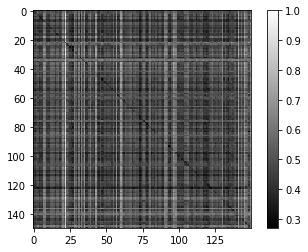

In [109]:
imshow(rsm_out_full_fc7,cmap='gray')
colorbar()

In [2]:
abc = np.load('fitness_results.npy')

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/u830238/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['beta', 'imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


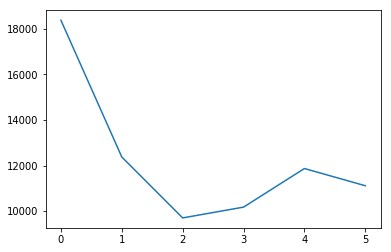

In [14]:
plot(abc[3,0,:])